# LGBM Inference

In [23]:
import pandas as pd
import os
import random
import math
from tqdm import tqdm
import numpy as np
import time

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import torch

## 데이터 로드

In [24]:
train = pd.read_csv("/opt/ml/input/data/train_dataset/cv_train_data_FE.csv")
valid = pd.read_csv("/opt/ml/input/data/train_dataset/cv_valid_data_FE.csv")
test = pd.read_csv('/opt/ml/input/data/train_dataset/test_data_FE.csv')

In [25]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,hour,dow,elapsed,grade,...,retest,solved_disorder,last_problem,answer_delta,tag_delta,test_delta,assess_delta,left_asymptote,elo_prob,cum_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,1,0.0,6,...,0,0,0,0.290768,0.044978,0.052317,0.017937,0,0.979350,1.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0,1,3.0,6,...,0,0,0,0.290768,0.086813,0.052317,0.035874,0,0.970579,1.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0,1,8.0,6,...,0,0,0,0.290768,0.086813,0.052317,0.089686,0,0.942168,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0,1,7.0,6,...,0,0,0,0.290768,0.086813,0.052317,0.031390,0,0.972448,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0,1,7.0,6,...,0,0,0,0.290768,0.086813,0.052317,0.058296,0,0.957230,1.0


In [26]:
valid.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,hour,dow,elapsed,grade,...,retest,solved_disorder,last_problem,answer_delta,tag_delta,test_delta,assess_delta,left_asymptote,elo_prob,cum_correct
0,24,A090001001,A090000001,1,2020-02-18 06:42:34,4697,6,1,0.0,9,...,0,0,0,0.550052,0.397039,0.488255,0.588367,0,0.335942,0.000000
1,24,A090001002,A090000001,0,2020-02-18 06:44:39,4697,6,1,125.0,9,...,0,0,0,-0.449948,0.397039,-0.511745,-0.514541,0,0.461441,1.000000
2,24,A090001003,A090000001,1,2020-02-18 06:45:06,10174,6,1,27.0,9,...,0,0,0,0.550052,0.397039,0.488255,0.346756,0,0.603227,0.500000
3,24,A090001004,A090000001,1,2020-02-18 06:47:03,78,6,1,117.0,9,...,0,0,0,0.550052,0.397039,0.488255,0.525727,0,0.402934,0.666667
4,24,A090001005,A090000001,1,2020-02-18 06:47:12,78,6,1,9.0,9,...,0,0,0,0.550052,0.397039,0.488255,0.387025,0,0.538015,0.750000


In [27]:
test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,hour,dow,elapsed,grade,...,solve_order,retest,solved_disorder,last_problem,answer_delta,tag_delta,test_delta,assess_delta,left_asymptote,elo_prob
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,10,3,0.0,5,...,1,0,0,0,0.337382,0.412903,0.526786,0.250000,0,0.752296
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,10,3,26.0,5,...,2,0,0,0,0.337382,0.412903,0.526786,0.437500,0,0.416693
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,10,3,94.0,5,...,3,0,0,0,-0.662618,-0.588517,-0.473214,-0.343750,0,0.281076
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,10,3,5.0,5,...,4,0,0,0,-0.662618,-0.588517,-0.473214,-0.500000,0,0.382929
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,10,3,7.0,5,...,5,0,1,0,-0.662618,-0.581986,-0.473214,-0.281250,0,0.166432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,23,2,0.0,4,...,1,0,0,0,-0.644724,0.136364,-0.604762,-0.380952,0,0.132075
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,23,2,18.0,4,...,2,0,0,0,0.355276,0.136364,0.395238,0.476190,0,0.410814
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,23,2,21.0,4,...,3,0,0,0,0.355276,-0.776087,0.395238,0.238095,0,0.621880
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,23,2,89.0,4,...,4,0,0,0,0.355276,-0.776087,0.395238,0.142857,0,0.760312


In [28]:
# LEAVE LAST INTERACTION ONLY
test = test[test['userID'] != test['userID'].shift(-1)]
# DROP ANSWERCODE
test = test.drop(['answerCode'], axis=1)

In [29]:
test.head()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,hour,dow,elapsed,grade,mid,...,solve_order,retest,solved_disorder,last_problem,answer_delta,tag_delta,test_delta,assess_delta,left_asymptote,elo_prob
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,13,0,46.0,5,133,...,8,0,0,1,-1.662618,-1.542662,-1.661765,-1.470588,0,0.445639
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,2,6,23.0,7,146,...,8,0,0,1,-1.515691,-1.565693,-1.740385,-1.153846,0,0.136933
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,4,6,8.0,7,111,...,8,0,0,1,-1.515691,-1.446753,-1.417857,-1.285714,0,0.150526
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,5,4,75.0,9,64,...,6,0,0,1,-1.498492,-1.514286,-1.625000,-1.250000,0,0.520654
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,11,4,17.0,6,135,...,7,0,0,1,-1.733989,-1.602767,-1.678571,-1.321429,0,0.327865


## 카테고리 피쳐 라벨링

In [72]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_feats = ['grade']
label_feats = ['problem_number','hour','dow','solved_disorder','KnowledgeTag','testId','retest']
        
# 'problem_number','grade', 'testId','KnowledgeTag','problem_count','type_count','solved_disorder'

for c in ordinal_feats :
    X = train[c].values.reshape(-1,1)
    enc = OrdinalEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X
    
for c in label_feats :
    X = train[c].values.reshape(-1,1)
    enc = LabelEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [73]:
# 사용할 Feature 설정

# FEATS = ['testId', 
#        'KnowledgeTag', 'hour', 'dow', 'elapsed', 'grade', 'mid',
#        'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum',
#        'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'hour_mean', 'hour_sum',
#        'dow_mean', 'dow_sum', 'tag_elp', 'tag_elp_o', 'tag_elp_x', 'ass_elp',
#        'ass_elp_o', 'ass_elp_x', 'prb_elp', 'prb_elp_o', 'prb_elp_x',
#        'user_correct_answer', 'user_total_answer', 'user_acc', 'Grade_o',
#        'GradeCount', 'GradeAcc', 'GradeElp', 'GradeMElp', 'problem_count',
#        'tag_count', 'RepeatedTime', 'prior_KnowledgeTag_frequency',
#        'problem_position', 'solve_order', 'retest', 'solved_disorder',
#        'last_problem', 'answer_delta', 'tag_delta', 'test_delta',
#        'assess_delta', 'left_asymptote', 'elo_prob']
FEATS = ['last_problem', 'elapsed', 'grade', 'prior_KnowledgeTag_frequency','KnowledgeTag','testId','retest','hour','dow',"hour_mean", 'hour_sum', "dow_mean", 'dow_sum',
       'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'elo_prob',
#         'answer_delta', 
         'tag_delta', 
#          'test_delta',
#          'assess_delta',
       'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'tag_elp', 'tag_elp_o',
       'tag_elp_x', 'ass_elp', 'ass_elp_o', 'ass_elp_x', 'prb_elp',
       'prb_elp_o', 'prb_elp_x', 'user_correct_answer', 'user_total_answer',
       'user_acc', 'Grade_o', 'GradeCount', 'GradeAcc', 'GradeElp',
       'GradeMElp', 'problem_count', 'tag_count', 'RepeatedTime',
       'problem_position', 'solve_order', 'solved_disorder']
# FEATS = ['GradeAcc', 
# 'ass_mean', 
# 'RepeatedTime', 
# 'elo_prob', 
# 'ass_elp_o', 
# 'GradeMElp', 
# 'elapsed', 
# 'ass_elp_x', 
# 'grade', 'Grade_o', 
# 'GradeElp', 
# 'user_acc',
#  'test_mean', 
# 'ass_sum', 
# 'KnowledgeTag',
#  'tag_elp_x', 
# 'GradeCount', 
# 'user_correct_answer']


In [74]:
train.answer_delta.isnull().sum()

0

In [75]:
# ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
#        'KnowledgeTag', 'last_problem', 'elapsed', 'grade', 'mid',
#        'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum',
#        'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'tag_elp', 'tag_elp_o',
#        'tag_elp_x', 'ass_elp', 'ass_elp_o', 'ass_elp_x', 'prb_elp',
#        'prb_elp_o', 'prb_elp_x', 'user_correct_answer', 'user_total_answer',
#        'user_acc', 'Grade_o', 'GradeCount', 'GradeAcc', 'GradeElp',
#        'GradeMElp', 'problem_count', 'tag_count', 'RepeatedTime',
#        'problem_position', 'solve_order', 'solved_disorder']

# categorical 처리!!!

In [76]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_valid = valid['answerCode']
valid = valid.drop(['answerCode'], axis=1)

KeyError: 'answerCode'

In [77]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_valid = lgb.Dataset(valid[FEATS], y_valid)

## 4. 훈련 및 검증

In [83]:
'''
    original
'''
model = lgb.train(
                    {'objective': 'binary','metric':'auc', 'boosting':'dart'},
#                     {'objective': 'binary','metric':'auc','boosting':'dart',
#                      'learning_rate':0.05,'max_depth':15,'feature_fraction':0.8},
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=100,
                    num_boost_round=2500,
                    early_stopping_rounds=200
                )

preds = model.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1314167, number of negative: 693944
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6963
[LightGBM] [Info] Number of data points in the train set: 2008111, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654429 -> initscore=0.638567
[LightGBM] [Info] Start training from score 0.638567


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	training's auc: 0.846984	valid_1's auc: 0.844266
[200]	training's auc: 0.849642	valid_1's auc: 0.846731
[300]	training's auc: 0.851823	valid_1's auc: 0.848561
[400]	training's auc: 0.853152	valid_1's auc: 0.849537
[500]	training's auc: 0.854344	valid_1's auc: 0.850281
[600]	training's auc: 0.854877	valid_1's auc: 0.85056
[700]	training's auc: 0.855528	valid_1's auc: 0.850971
[800]	training's auc: 0.856034	valid_1's auc: 0.851166
[900]	training's auc: 0.85664	valid_1's auc: 0.851492
[1000]	training's auc: 0.857088	valid_1's auc: 0.851656
[1100]	training's auc: 0.857584	valid_1's auc: 0.85173
[1200]	training's auc: 0.857866	valid_1's auc: 0.851849
[1300]	training's auc: 0.858256	valid_1's auc: 0.851961
[1400]	training's auc: 0.858823	valid_1's auc: 0.852073
[1500]	training's auc: 0.859107	valid_1's auc: 0.852114
[1600]	training's auc: 0.859557	valid_1's auc: 0.8522
[1700]	training's auc: 0.860081	valid_1's auc: 0.852306
[1800]	training's auc: 0.860506	valid_1's auc: 0.852419
[1900]

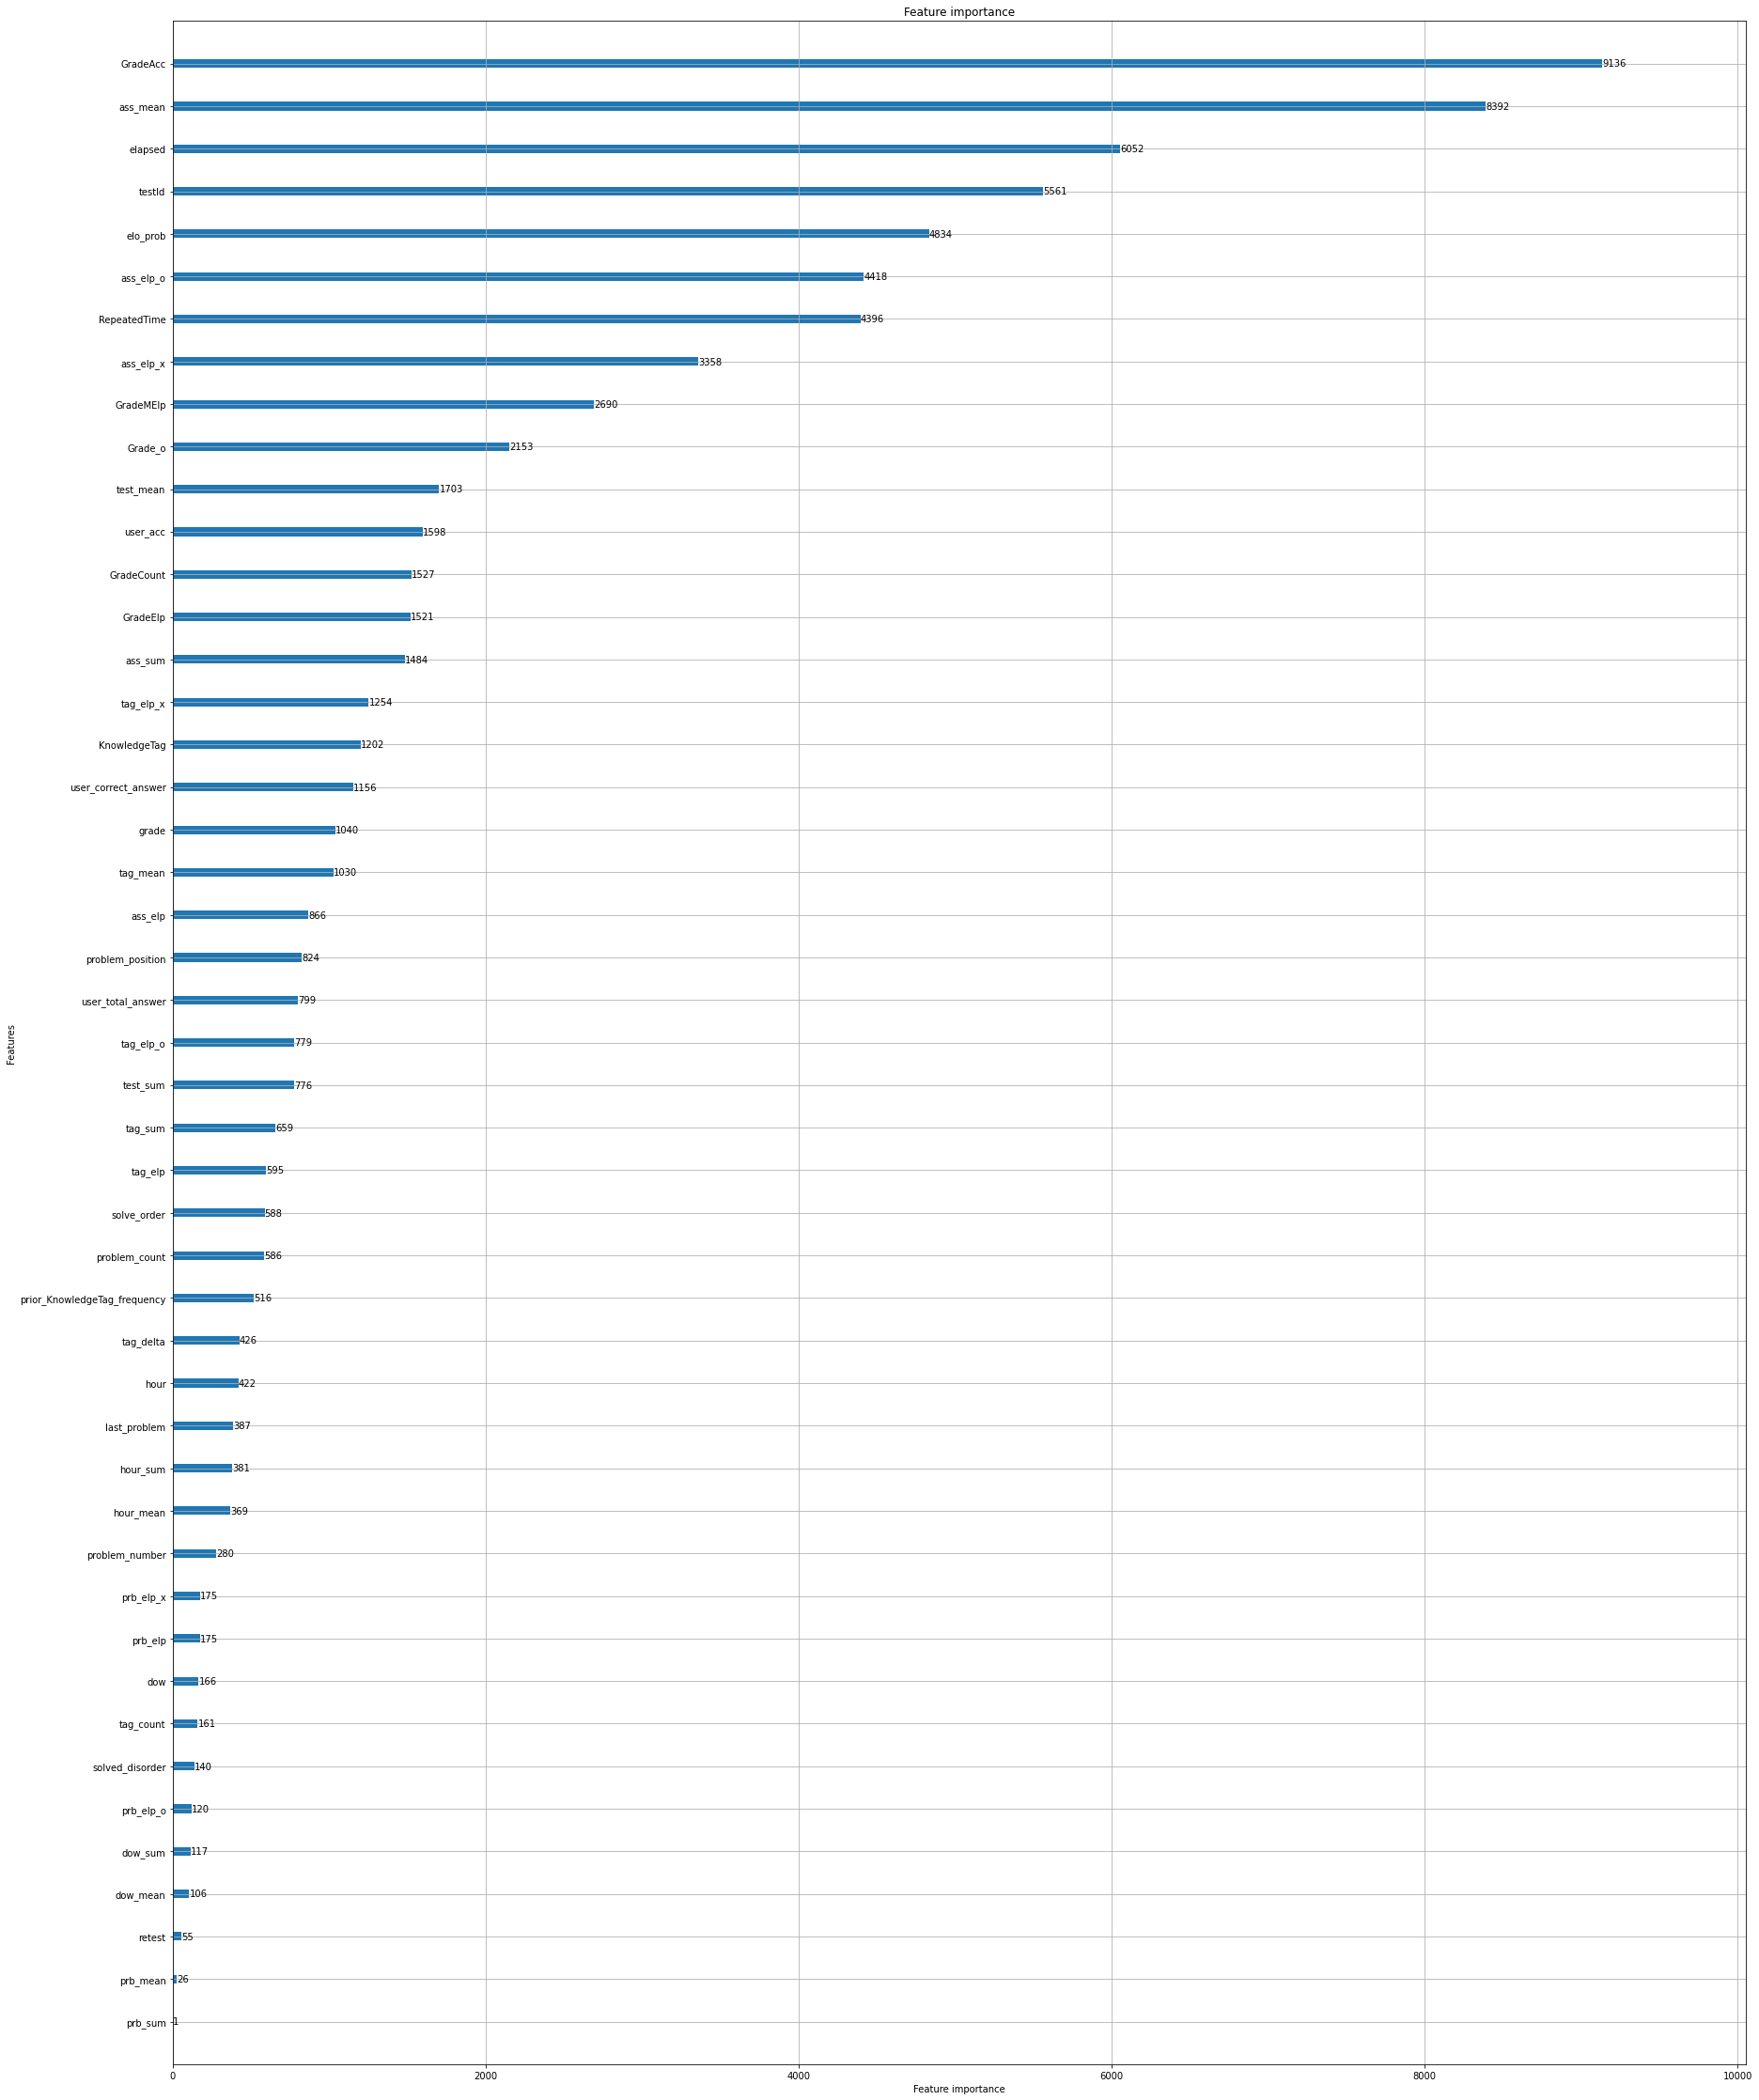

In [84]:
# Feature Importance 파악
import matplotlib.pyplot as plt
ax = lgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(30, 40)

## Inference

In [87]:
# MAKE PREDICTION
total_preds = model.predict(test[FEATS])

In [88]:
# SAVE OUTPUT
output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM_delta (dart).csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM_delta (dart).csv


In [89]:
total_preds

array([0.42981197, 0.73317962, 0.20878226, 0.71404156, 0.34309193,
       0.89261843, 0.13754943, 0.26045276, 0.18921305, 0.248498  ,
       0.48331241, 0.50706979, 0.93824669, 0.10003294, 0.6799785 ,
       0.94621681, 0.20631738, 0.84827318, 0.86954592, 0.2485834 ,
       0.94444468, 0.5227315 , 0.69048054, 0.3334456 , 0.25295162,
       0.70697584, 0.90745033, 0.90438529, 0.57356483, 0.80637719,
       0.80723546, 0.62042345, 0.9179808 , 0.21488365, 0.79946027,
       0.83238484, 0.20491752, 0.57276969, 0.47319817, 0.2403569 ,
       0.73906046, 0.16996159, 0.19903405, 0.42857815, 0.57974922,
       0.73431055, 0.67586338, 0.24311696, 0.95105816, 0.75233288,
       0.6631328 , 0.27666646, 0.38220791, 0.12916259, 0.38087751,
       0.72473403, 0.37619612, 0.96055158, 0.03315237, 0.20690093,
       0.87871303, 0.94655156, 0.70288386, 0.2336257 , 0.13179903,
       0.38294433, 0.72919194, 0.27201092, 0.22852364, 0.38907666,
       0.72249917, 0.87694345, 0.06169945, 0.22554944, 0.43677